# Mujoco-environment
## Algorithm : **REINFORCE**

## Reference :
- https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/
- https://kimjy99.github.io/프로그래밍/mujoco/

## **Setting**

In [ ]:
!pip install gymnasium
!pip install gymnasium[mujoco]
!pip install pyvirtualdisplay
!sudo apt-get install xvfb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 25.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd6

In [ ]:
#!pip install opencv-python==4.8.0.74
#!pip install xvfbwrapper

In [ ]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

import gymnasium as gym

from pyvirtualdisplay import Display
import PIL.Image
from IPython.display import Image

## **REINFORCE** code

In [ ]:
class Policy_Network(nn.Module):
    def __init__(self, state_space_dim: int, action_space_dim: int):
        super().__init__()
        hidden_space1 = 16
        hidden_space2 = 32

        self.shared_net = nn.Sequential(
            nn.Linear(state_space_dim, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dim)
        )
        self.policy_std_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dim)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:

        shared_features = self.shared_net(x.float())

        action_mean = self.policy_mean_net(shared_features)
        action_std = torch.log(
            1 + torch.exp(self.policy_std_net(shared_features))
        )

        return action_mean, action_std

In [ ]:
class REINFORCE:
    def __init__(self, state_space_dims: int, action_space_dims: int):
        self.learning_rate = 1e-4
        self.gamma = 0.99
        self.eps = 1e-6

        self.log_probs = []
        self.rewards = []

        self.net = Policy_Network(state_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        state = torch.tensor(np.array([state]))
        action_mean, action_std = self.net(state)

        distrib = Normal(action_mean[0] + self.eps, action_std[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)   #log(Prob) for REINFORCE

        action = action.numpy()

        self.log_probs.append(prob)

        return action

    def update(self): # Update per Episode
        running_g = 0
        g_t = []

        # Discounted return (backwards)
        for R in self.rewards[::-1]:  # [::-1] will return an array in reverse
            running_g = R + self.gamma * running_g #G(t) = r(t+1) + gamma * G(t+1)
            g_t.insert(0, running_g) # insert(index, value)

        G_t = torch.tensor(g_t)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, g_t in zip(self.log_probs, G_t):
            loss +=  (-1) * log_prob.mean() * g_t

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # reset for next episode
        self.log_probs = []
        self.rewards = []

In [ ]:
def train(max_episode:int, check:int, trial_num :int, env_name="InvertedPendulum-v4" ):
    env = gym.make(env_name)
    wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50) # Records episode-reward

    state_space_dim = env.observation_space.shape[0]
    action_space_dim = env.action_space.shape[0]
    rewards_over_trial = []

    trial=1
    start= time.time()
    for seed in [10*i for i in range(1,trial_num+1)]:
        print(f"[trial : {trial}]")
        # set seed
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        agent = REINFORCE(state_space_dim, action_space_dim)
        reward_episode = []

        for episode in range(1, max_episode+1):

            state, info = wrapped_env.reset(seed=seed)

            done = False
            while not done:
                action = agent.sample_action(state)

                state, reward, terminated, truncated, info = wrapped_env.step(action)
                agent.rewards.append(reward)

                done = terminated or truncated

            reward_episode.append(int(wrapped_env.return_queue[-1])) # episode return
            agent.update()

            if episode % check == 0:
                print(f"Episode: {episode}, Total Reward: {reward_episode[-1]}")

        rewards_over_trial.append(reward_episode)
        trial+=1
        end =time.time()
        print(f'Training_time : {(end-start)/60:.2f}(min)')

    return agent, rewards_over_trial

In [ ]:
def plot_save(rewards, title:str, save_path=None):

    high= np.max(rewards , axis= 0)
    low= np.min(rewards , axis= 0)
    mean= np.mean(rewards , axis= 0)

    plt.figure(figsize=[4,2], dpi=300)
    plt.title(title , fontsize=9)
    plt.xlabel('Episodes', fontsize=7)
    plt.ylabel('Total Rewards', fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)

    x= np.arange(1, len(rewards[0])+1)
    # plt.plot(x, high, 'b-', linewidth=.1, alpha=0.2)
    # plt.plot(x, low, 'b-', linewidth=.1, alpha=0.2)
    plt.plot(x, mean, 'b-', linewidth=.2)

    if save_path!=None:
        plt.savefig(save_path, format='png')

    plt.show()

In [ ]:
def play_and_save(env, agent, name='', seed=None):
    render_images = []
    rewards = []

    state, _ = env.reset(seed=seed)
    image_array = env.render()
    render_images.append(PIL.Image.fromarray(np.array(image_array)))

    terminated = False
    truncated = False

    while not terminated and not truncated:
        action = agent.sample_action(state)
        state, reward, terminated, truncated,  _ = env.step(action)
        rewards.append(reward)
        image_array = env.render()
        render_images.append(PIL.Image.fromarray(np.array(image_array)))


    filename = name+'.gif'

    render_images[0].save(filename, save_all=True, optimize=False, append_images=render_images[1:], duration=100, loop=0)
    print(f'Episode Length : {len(render_images)}')
    print(f'Total rewards : {sum(rewards)}')
    print('GIF is made successfully!')

    return filename

## Training and Visualize

In [ ]:
environment={
    0: "HalfCheetah-v4",
    1: "Hopper-v4",
    2: "Walker2d-v4",
    3: "Ant-v4",
    4: "Reacher-v4",
    5: "InvertedPendulum-v4",
    6: "InvertedDoublePendulum-v4"
}

In [ ]:
i=1

In [ ]:
agent, rewards =train(max_episode= 50, check= 5, trial_num=1 ,env_name=environment[i])

[trial : 1]
Episode: 5, Total Reward: 8


<ipython-input-71-32948846cf5e>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_episode.append(int(wrapped_env.return_queue[-1])) # episode return


Episode: 10, Total Reward: 9
Episode: 15, Total Reward: 8
Episode: 20, Total Reward: 8
Episode: 25, Total Reward: 26
Episode: 30, Total Reward: 8
Episode: 35, Total Reward: 7
Episode: 40, Total Reward: 11
Episode: 45, Total Reward: 59
Episode: 50, Total Reward: 6
Training_time : 0.02(min)


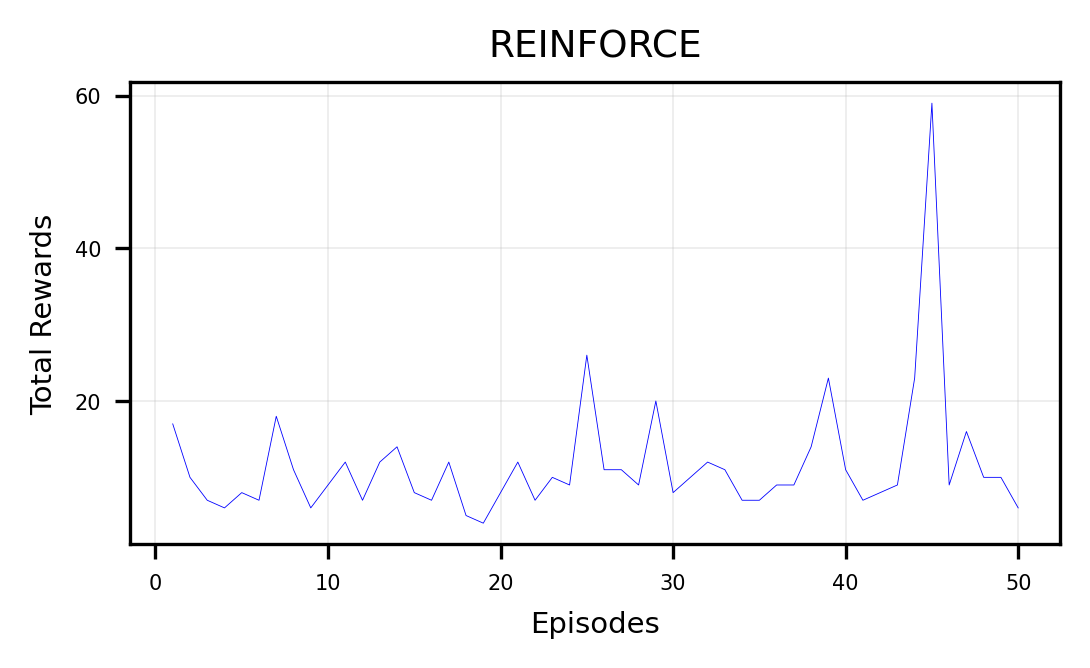

In [ ]:
plot_save(rewards=rewards, title='REINFORCE',save_path=None )

In [ ]:
display = Display(visible=0, size=(140, 90))
display.start()

env = gym.make(environment[i], render_mode="rgb_array" )
saved_fname = play_and_save(env, agent, 'test', seed=10)

Episode Length : 16
Total rewards : 15.51139001491894
GIF is made successfully!


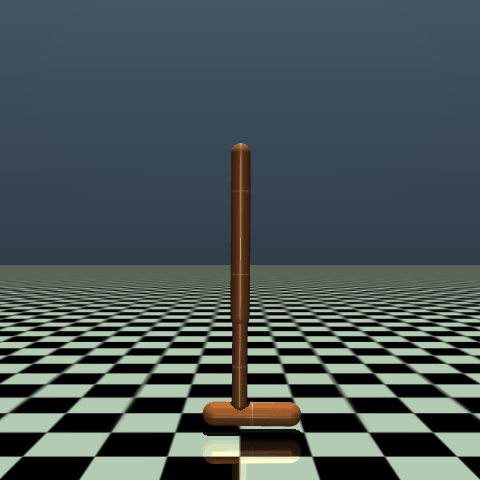

In [ ]:
Image(open(saved_fname,'rb').read())

In [ ]:
np.max(rewards , axis= 0)

array([17, 10,  7,  6,  8,  7, 18, 11,  6,  9, 12,  7, 12, 14,  8,  7, 12,
        5,  4,  8, 12,  7, 10,  9, 26, 11, 11,  9, 20,  8, 10, 12, 11,  7,
        7,  9,  9, 14, 23, 11,  7,  8,  9, 23, 59,  9, 16, 10, 10,  6])

In [ ]:
np.min(rewards , axis= 0)

array([17, 10,  7,  6,  8,  7, 18, 11,  6,  9, 12,  7, 12, 14,  8,  7, 12,
        5,  4,  8, 12,  7, 10,  9, 26, 11, 11,  9, 20,  8, 10, 12, 11,  7,
        7,  9,  9, 14, 23, 11,  7,  8,  9, 23, 59,  9, 16, 10, 10,  6])

In [ ]:
np.mean(rewards , axis= 0)

array([ 0.,  3.,  2.,  6., -2.,  8., -6., -2.,  0., 14.,  0., -1., -1.,
        1.,  2.,  0.,  0., 12.,  6.,  0.,  9., -5.,  5.,  3.,  4.,  5.,
        0.,  3., -3., 11., 10.,  3.,  1., -4.,  6., -4.,  8., -5.,  1.,
        1.,  5.,  3., 23., 31.,  0.,  0.,  0., -6.,  8., -5.])

In [ ]:
seed=None
render_images = []
rewards = []

state, _ = env.reset(seed=seed)
image_array = env.render()
render_images.append(PIL.Image.fromarray(np.array(image_array)))

terminated = False
truncated = False

while not terminated and not truncated:
        action = agent.sample_action(state)
        state, reward, terminated, truncated,  _ = env.step(action)
        rewards.append(reward)
        image_array = env.render()
        render_images.append(PIL.Image.fromarray(np.array(image_array)))

In [ ]:
rewards

[0.9761906453266858,
 0.9088529512389121,
 0.9062564497212083,
 0.9316566505263291,
 0.9415188137422003,
 1.0227324766515722,
 1.0868189665741228,
 1.0272994523289973,
 0.9737557884442272,
 0.9209433545667076,
 0.8928963627992886,
 0.909983862974078,
 0.9418880897676567,
 0.9170988923301386,
 0.8105671866317998,
 0.6976002928173909,
 0.6085437003100067]

In [ ]:
sum(rewards)

15.474603936751322